# Clipping netCDF files from ACOLITE output

https://stackoverflow.com/questions/65495830/masking-netcdf-file-with-shapefile-using-geopandas-python

This script runs in SMCE using the largest server option (16gb memory). I needed to restart the kernel after processing each image to avoid running out of memory.

In [1]:
import netCDF4
import numpy as np
from osgeo import gdal,osr,ogr
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import xarray as xr
import gc

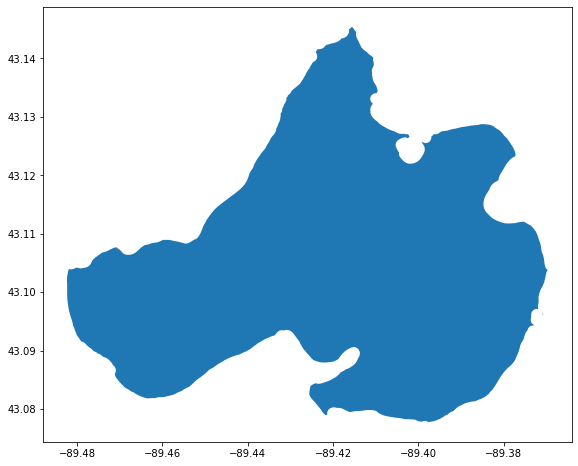

In [2]:
# read in file path for shapefile
lake_shp = "/efs/Shapefiles/LakeMendota_100m_offset/Mendota_100m_offset.shp"

# Read shapefile using gpd.read_file()
shp = gpd.read_file(lake_shp)

# quick check for shpfile plotting
shp.plot(figsize=(12, 8));

In [3]:
# read in netcdf file path
ncs = "/efs/DESIS/L2R/DESIS_HSI_028_2022_10_10_15_54_14_L2R.nc"

In [4]:
# Read in NETCDF with Xarray
ds = xr.open_dataset(ncs)
print("ds open")
# convert to pandas dataframe (this step takes longest / most memory)
edgar = ds.to_dataframe()
print("ds to dataframe")
# the index in the df is a Pandas.MultiIndex. To reset it, use df.reset_index()
edgar = edgar.reset_index()
print("index reset")

#free up memory
del ds
gc.collect()

ds
edgar
reset


504

In [5]:
# use geopandas points_from_xy() to transform Longitude and Latitude into a list of shapely.Point objects and set it as a geometry while creating the GeoDataFrame
edgar_gdf = gpd.GeoDataFrame(edgar, geometry=gpd.points_from_xy(edgar.lon, edgar.lat))

print(edgar_gdf.head())

   y  x        lon        lat  rhot_401  rhos_401  rhot_404  rhos_404  \
0  0  0 -89.597443  43.375080       NaN       NaN       NaN       NaN   
1  0  1 -89.597069  43.375088       NaN       NaN       NaN       NaN   
2  0  2 -89.596703  43.375095       NaN       NaN       NaN       NaN   
3  0  3 -89.596329  43.375107       NaN       NaN       NaN       NaN   
4  0  4 -89.595963  43.375114       NaN       NaN       NaN       NaN   

   rhot_407  rhos_407  ...  rhos_992  rhot_993  rhos_993  rhot_996  rhos_996  \
0       NaN       NaN  ...       NaN       NaN       NaN       NaN       NaN   
1       NaN       NaN  ...       NaN       NaN       NaN       NaN       NaN   
2       NaN       NaN  ...       NaN       NaN       NaN       NaN       NaN   
3       NaN       NaN  ...       NaN       NaN       NaN       NaN       NaN   
4       NaN       NaN  ...       NaN       NaN       NaN       NaN       NaN   

   rhot_998  rhos_998  rhot_1000  rhos_1000                    geometry  
0     

In [6]:
# A lot of this is commented out because I am using the same shapefile over and over. Make sure to check the coordinates when you start

# check CRS coordinates
# shp.crs #shapefile 
    # <Geographic 2D CRS: EPSG:4326>
    # Name: WGS 84
    # Axis Info [ellipsoidal]:
    # - Lat[north]: Geodetic latitude (degree)
    # - Lon[east]: Geodetic longitude (degree)
    # Area of Use:
    # - name: World.
    # - bounds: (-180.0, -90.0, 180.0, 90.0)
    # Datum: World Geodetic System 1984 ensemble
    # - Ellipsoid: WGS 84
    # - Prime Meridian: Greenwich
    
# print(edgar_gdf.crs) #geodataframe netcdf - none

# set coordinates equal to each other
# PointsGeodataframe.crs = PolygonsGeodataframe.crs
edgar_gdf.crs = shp.crs
# check coordinates after setting coordinates equal to each other
edgar_gdf.crs #geodataframe netcdf
print(edgar_gdf.crs)

epsg:4326


In [7]:
# Clip points, lines, or polygon geometries to the mask extent.
mask = gpd.clip(edgar_gdf, shp)

<AxesSubplot:>

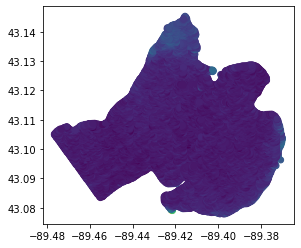

In [8]:
#check that clipped data plots correctly
mask.plot.geo(column = 'rhos_665')

In [9]:
# Get filenames to save

image_id = ncs.split("L2R/")[1].split("L2R")[0]
fileID = image_id + "Mendota.csv"

# Save clipped dataframe
mask.to_csv("/efs/DESIS/L2R_clips/" + fileID)

<AxesSubplot:>

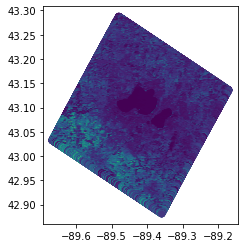

In [9]:
# To check how the plot of the unclipped file looks:
# edgar_gdf.plot.geo(column = 'rhos_665')